In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dask import delayed
from dask.distributed import Client, progress
import dask.array as da
import dask.dataframe as dd
import joblib
import pandas as pd
import spacy

import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.3f}'.format
sns.set(style='whitegrid', palette='colorblind', color_codes=True, font_scale=2)

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
def print_nulls(ddf):
    out = ddf.isnull().sum()*100/ddf.isnull().isnull().count()
    
    return print_full(out.compute())

In [3]:
def plot_hist_boxplot(df):
    '''
    Accepts only numerical columns;
    use a maks.
    '''
    dim = df.shape[1]
    plt.figure(figsize=(20, dim*5))
    
    # iterate through the columns
    for i, column in enumerate(df.columns):
        
        # plot a histogram
        plt.subplot(dim, 2, (i+1)*2-1)
        plt.hist(df[column])
        plt.ylabel(column, size='xx-large')
        
        # plot a boxplot
        plt.subplot(dim, 2, (i+1)*2)
        plt.boxplot(df[column], whis=[2.5, 97.5]) # boxplot will show outliers beyond the inner 90th percentile
    plt.show()

In [4]:
client = Client(n_workers=1, threads_per_worker=8)
client

Client Scheduler: tcp://127.0.0.1:41051 Dashboard: http://127.0.0.1:35239/status,Cluster Workers: 1 Cores: 8 Memory: 16.71 GB


In [5]:
# List the columns that I am going to use
# Many columns contain duplicate or unnecessary information. These are the essential features

kept = ['vin' 
        , 'make_name' # Use make and body type instead of model
        #, 'model_name'
        , 'body_type'
        , 'year'
        , 'engine_type' # This contains the number of cylnders as well as their configureation.   
        , 'wheel_system'
        , 'transmission'
        #, 'trimId'
        #, 'trim_name'
        , 'horsepower'
        , 'maximum_seating'
        , 'mileage'
        
        
        # Target Variable
        , 'price'

        # Fuel Economy Variables
        , 'fuel_type'  
        , 'city_fuel_economy'
        , 'highway_fuel_economy'
        , 'combine_fuel_economy'

        , 'daysonmarket'
        , 'franchise_dealer'
        , 'is_cpo'
        
        # These Features would need NLP
        #, 'description'
        #, 'major_options'
        #, 'exterior_color'
        #, 'interior_color'

        # Low nulls but probably just noise
        #, 'front_legroom'
        #, 'back_legroom'
        #, 'height'
        #, 'length'
        #, 'width'

        # Vehicle History Features
        #, 'owner_count' 50% nulls vs other history features
        , 'has_accidents'       
        , 'salvage'
        , 'theft_title'
        , 'fleet'
        , 'frame_damaged'
        , 'isCab' # Guessing this indicates that it was used for ridesharing?
        
        # Location information not currently utilized
        #, 'dealer_zip'
        #, 'latitude'
        #, 'longitude'
       ]

In [6]:
# read the first 10,000 rows in pandas to do understand the data structure
df = pd.read_csv(r'/home/owen/Jupyter/Capstone 4: Final Capstone/used_cars_data.csv', usecols=kept, nrows=10000)

In [7]:
# Use the pandas type assignments for dask
dtypes = {col : df[col].dtype for col in df.columns}

# This contains problem values probably 4 digit codes
#dtypes['dealer_zip'] = 'O'

In [8]:
# Keep only the dtypes for the columns that I want
#dtypes = {key : dtypes[key] for key in dtypes if key in kept}

#df = dd.from_pandas(df, npartitions=5)

df = dd.read_csv('used_cars_data.csv', usecols=kept, dtype=dtypes)

In [9]:
def clean(df):
    ### Operations to clean the dataset
    '''
    In this iteration it is mostly some simple fixes to retain and retype easy to clean data.
    Almost half the data are being dropped because they lack car history values.

    Some notes are included for currently unused columns.
    '''

    #First Drop Duplicates
    df = df.drop_duplicates(subset='vin')

    # Limit the model to vehicles with NHTSA data available
    df = df[df['year'] > 1984]
    '''
    Helps limit the influence of collector cars since this is aimed toward
    the general consumer
    '''

    # Clean up boolean columns into numerical
    df['is_cpo'] = df['is_cpo'].apply(lambda x: 1 if x == True else 0)

    df['franchise_dealer'] = df['franchise_dealer'].apply(lambda x: 1 if x == True else 0)

    df['fleet'] = df['fleet'].apply(lambda x: 1 if x == True else 0)

    df['frame_damaged'] = df['frame_damaged'].apply(lambda x: 1 if x == True else 0)

    df['isCab'] = df['isCab'].apply(lambda x: 1 if x == True else 0)

    df['has_accidents'] = df['has_accidents'].apply(lambda x: 1 if x == True else 0)

    df['salvage'] = df['salvage'].apply(lambda x: 1 if x == True else 0)

    df['theft_title'] = df['theft_title'].apply(lambda x: 1 if x == True else 0)

    # Clean and retype seating capacity 
    def fix_seating(r):
        try:
            r = int(str(r).strip(' seats'))
            return r
        except:
            return np.nan

    df['maximum_seating'] = df['maximum_seating'].apply(fix_seating, meta=
                                                        ('maximum_seating', 'int64'))
    # Decide what to do about fuel economy
    '''
    It could be best to calculate an overall cost of ownership that would take fuel into account.
    Within this model currently there is not a good option to assign a fuel economy value to electric 
    vehicles

    Drop the component features due to correlation problems
    '''

    # EPA generates combined by weighting city 55% and highway 45%
    df['combine_fuel_economy'] = df['city_fuel_economy']*0.55 + df['highway_fuel_economy']*0.45

    df = df.drop(['city_fuel_economy', 'highway_fuel_economy'], axis=1)

    # Use vin as index?
    '''
    May additionally need to add a vin checker here

    Skipping for now because it is expensive and not useful yet

    df = df.set_index('vin')
    '''


    # Drop almost half the dataset because it is missing history?, Drop those features?
    '''
    In this pass I'm going to retain these columns and shrink the data. 
    There is still more than enough and this way I may be able to create a classifier to
    recommend if purchasing history will be worth it or not.

    In the overall dataset these values have a null rate of about 45%


    ['fleet'
    , 'frame_damaged'
    , 'isCab'
    , 'has_accidents'
    , 'salvage'
    , 'theft_title']

    '''

    # Color and Description both need to be parsed
    '''
    Just dropping them in this pass
    '''    

    # Define a function to retype columns with unit inches
    '''
    def strip_inches(t):
        try:
            t = float(str(t).strip(' in'))
            return t
        except:
            return np.nan

    cols = ['back_legroom', 'front_legroom', 'height', 'width', 'length']

    for col in cols:
        df[col] = df[col].apply(strip_inches, meta=(col, 'int64'))
    '''    

    # See if I can bin TrimID better
    '''
    Drop them in this pass
    '''
    
    # Drop the remaining nulls
    '''
    Unfortounately at this point that includes all vehicles that are primarily electric
    because they have null fuel economy values
    
    A possible fix for this would be to use fuel economy and the cost of fuel to calculate a 
    price per mile. EPA has data that could be used to produce these estimates
    '''
    df = df.dropna()
    
    return df


In [10]:
df = clean(df)

In [11]:
df = df.persist()

In [12]:
print_nulls(df)

vin                     0.000
body_type               0.435
combine_fuel_economy   16.261
daysonmarket            0.000
engine_type             3.230
fleet                   0.000
frame_damaged           0.000
franchise_dealer        0.000
fuel_type               2.639
has_accidents           0.000
horsepower              5.624
isCab                   0.000
is_cpo                  0.000
make_name               0.000
maximum_seating         5.201
mileage                 4.783
owner_count            50.509
price                   0.000
salvage                 0.000
theft_title             0.000
transmission            2.123
wheel_system            4.772
year                    0.000
dtype: float64


In [14]:
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 23 entries, vin to year
dtypes: object(7), float64(5), int64(11)

In [15]:
df = df.dropna()

In [16]:
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 22 entries, vin to year
dtypes: object(7), float64(4), int64(11)

In [19]:
df.shape[0].compute()

2338024

<Figure size 1440x1440 with 0 Axes>

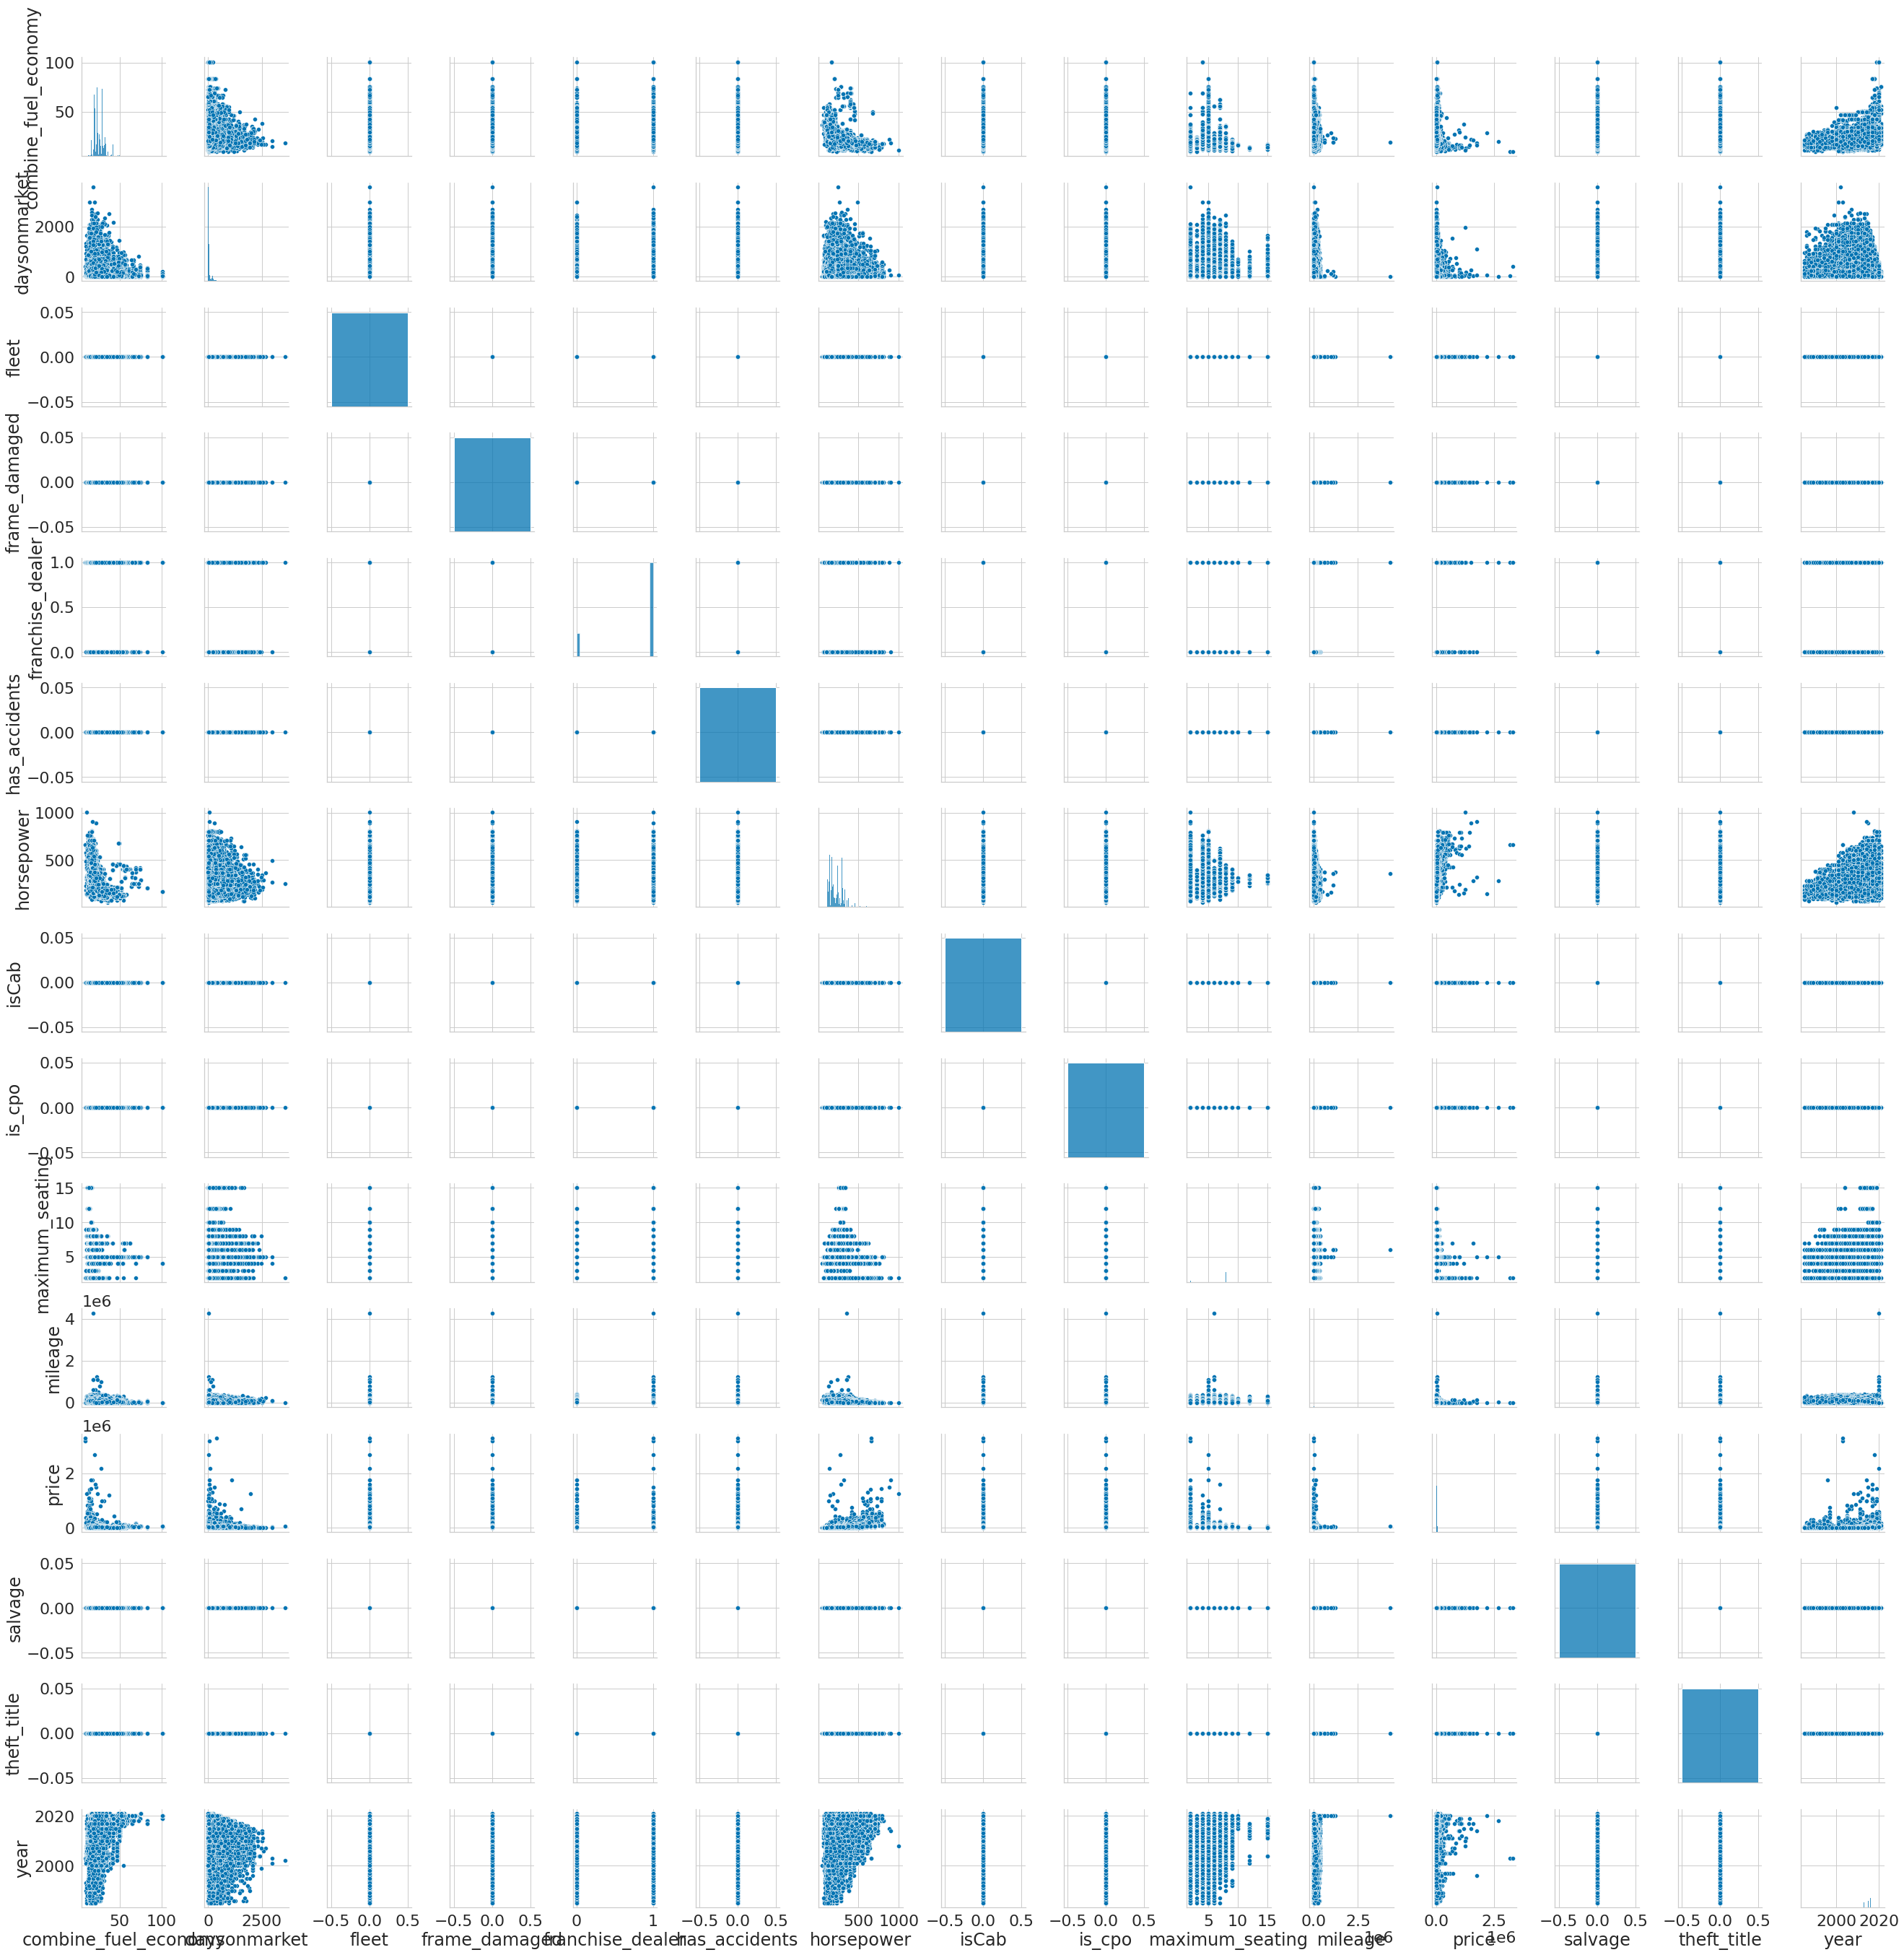

In [23]:
plt.figure(figsize=(20,20))
sns.pairplot(df.compute())

In [24]:
print_nulls(df)

vin                    0.000
body_type              0.000
combine_fuel_economy   0.000
daysonmarket           0.000
engine_type            0.000
fleet                  0.000
frame_damaged          0.000
franchise_dealer       0.000
fuel_type              0.000
has_accidents          0.000
horsepower             0.000
isCab                  0.000
is_cpo                 0.000
make_name              0.000
maximum_seating        0.000
mileage                0.000
price                  0.000
salvage                0.000
theft_title            0.000
transmission           0.000
wheel_system           0.000
year                   0.000
dtype: float64
